In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as date
print("Modules Imported")

Modules Imported


In [5]:
#Connect to drive
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#os.chdir("drive/MyDrive/Honours/")
os.listdir()

['assist.csv',
 'ZZ_EEDI_BKT_v1_(JAKE).ipynb',
 'ZZ_Eedi data first exploration.R',
 'investigate.py',
 'BKT.py',
 'Formatting.ipynb',
 '.ipynb_checkpoints',
 'data',
 'Docs N Stuff',
 'BKT.ipynb',
 'student1.csv',
 'student2.csv',
 'student3.csv',
 'running_hot_again.csv',
 'running_hot.csv',
 'ccrs.csv',
 'predictions.csv',
 'grouped_predictions.csv',
 'model_params',
 'average_mastery_predictions.png',
 'bkt_example.png',
 'fast_and_slow.png',
 'trimmed_assist.csv',
 'assist_ccrs.csv',
 'preds.csv',
 'assist_preds.csv',
 'assist_master.csv',
 'assist_params.csv',
 'very_slow.png',
 'Marked_Examlpes.png',
 'Marked_Examples.png',
 'Marked_all.png',
 'Marked_fast_slow.png']

In [7]:
master = pd.read_csv("data/master.csv")
ccrs = pd.read_csv("data/ccrs.csv")
preds = pd.read_csv("predictions.csv")
params = pd.read_csv("data/model_params.csv")
print("Data loaded")

Data loaded


In [ ]:
#The questions with multiple level 2 topics are question 2 and 849
#These should already be removed, but just in case
master = master[(master["QuestionId"] != 2) & (master["QuestionId"] != 849)]

In [8]:
preds.drop(["Unnamed: 0", "DateOfBirth", "correct_predictions", "state_predictions"], axis = 1, inplace = True)
params.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [9]:
times = []
for i in range(len(preds)):
  times.append(date.datetime.strptime(preds.iloc[i]["DateAnswered"], '%Y-%m-%d %H:%M:%S.%f'))

preds.drop(["DateAnswered"], axis = 1, inplace = True)
preds["DateAnswered"] = times

In [10]:
length = len(preds)
timeLimit = date.timedelta(days= 0, hours = 0, minutes = 10)
timeToAnswer = [-1]

for i in range(1, (length)):
  timeNow = preds.iloc[i]["DateAnswered"]
  timePrev = preds.iloc[i - 1]["DateAnswered"]
  timeTaken = timeNow - timePrev
  if (timeTaken > timeLimit):
    timeToAnswer.append(-1)
  else:
    timeToAnswer.append(timeTaken.total_seconds() / 60)

#timeToAnswer

In [11]:
preds["TimeToAnswer"] = timeToAnswer

In [12]:
preds

,QuestionId,UserId,AnswerId,IsCorrect,Name,SubjectId,Gender,PremiumPupil,max_CCR_for_subject,3 CCR,5 CCR,10 CCR,DateAnswered,TimeToAnswer
0,199,3,1160716,1,Negative Numbers,42,1,0.0,78,1,1,1,2019-10-30 18:48:00,-1.0
1,911,3,1114855,1,Negative Numbers,42,1,0.0,78,1,1,1,2019-10-30 18:50:00,2.0
2,405,3,376576,1,Negative Numbers,42,1,0.0,78,1,1,1,2019-10-30 18:54:00,4.0
3,547,3,968084,1,Negative Numbers,42,1,0.0,78,1,1,1,2019-10-30 18:58:00,4.0
4,461,3,185605,1,Negative Numbers,42,1,0.0,78,1,1,1,2019-11-08 08:01:00,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139528,271,6140,342151,0,Transformations,278,2,0.0,3,1,0,0,2020-04-03 06:31:00,0.0
139529,247,6140,865533,1,Transformations,278,2,0.0,3,1,0,0,2020-04-03 06:32:00,1.0
139530,411,6140,1199486,1,Transformations,278,2,0.0,3,1,0,0,2020-04-03 06:33:00,1.0
139531,947,6140,1230600,1,Transformations,278,2,0.0,3,1,0,0,2020-04-03 06:33:00,0.0


In [13]:
x = (len(preds))
y = (len( preds[(preds["TimeToAnswer"] > 3) & (preds["TimeToAnswer"] < 10)]  ))

print(x)
print(y)
print(y/x)

139533
6217
0.044555768169536956


In [14]:
priors_dict = dict(zip(params.Name, params.priors))
learns_dict = dict(zip(params.Name, params.learns))
guesses_dict = dict(zip(params.Name, params.guesses))
slips_dict = dict(zip(params.Name, params.slips))

In [15]:
priors_dict["Units of Measurement"]

0.1369248815436303

In [16]:
#Define Params
prior = 0.3266     #P(L0)
learns = 0.0098    #P(T)
guesses = 0.3545   #P(G)
slips = 0.2007     #P(S)

mul1 = 2.5
mul2 = 1.5
mul3 = 0.5
mul4 = 0.5

In [17]:
def predict(corrects, timesToAnswer):#, prior, learns, guesses, slip):

  isCorrect = corrects[-1]
  timeToAnswer = timesToAnswer[-1]
  if (timeToAnswer == 0):
    slip = slips * mul1
  elif (timeToAnswer == 1):
    slip = slips * mul2
  elif (timeToAnswer == 2):
    slip = slips * mul3
  else:
    slip = slips * mul4

  if (len(corrects) == 1):
    previous = prior
  else:
    previous = predict(corrects[0:-1], timesToAnswer[0:-1])#, prior, learns, guesses, slips)

  if (isCorrect == True):
    numerator = (1 - learns) * (1 - previous) * guesses
    denominator = guesses + ((1 - slip - guesses) * previous)
    result = 1 - (numerator / denominator)
    return result

  if (isCorrect == False):
    numerator = (1 - learns) * (1 - previous) * (1 - guesses)
    denominator = 1 - guesses - ((1 - slip - guesses) * previous)
    result = 1 - (numerator / denominator)
    return result

In [18]:
fastTimes =       [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0]
slowTimes =       [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
verySlowTimes =   [1,1,1,1,1,1,1,1,1,1,2,2,2,2,2]
answervals =    [0,1,0,1,1,1,1,1,0,1,0,0,1,0,0,1]
               #[1,2,3,4,5,6,7,8,9,0,1,2,3,4,5]

def mini_predictions(answerVals, timeVals):
  test_predictions = []

  for i in range(1, len(answerVals)):
    answers = answerVals[0:(i)]#.values
    times = timeVals[0:(i)]#.values
    #print(answers)

    prediction = predict(answers, times)
    test_predictions.append(prediction)

  return test_predictions

In [19]:
slow_preds = mini_predictions(answervals, slowTimes)
fast_preds = mini_predictions(answervals, fastTimes)
very_slow = mini_predictions(answervals, verySlowTimes)
#slow_preds = (np.round(predictions, decimals = 5))

In [20]:
pyBKT_preds = [0.16392, 0.32265, 0.15312, 0.30524, 0.51602, 0.72114, 0.86247, 0.93829, 0.85167, 0.93299, 0.84018, 0.92726, 0.82799, 0.64517, 0.40738]
pyBKT_preds2 = [0.16352, 0.32201, 0.15269, 0.30454, 0.51519, 0.72047,
       0.86207, 0.9381 , 0.85119, 0.93275, 0.83962, 0.66406, 0.8274 ,
       0.64413, 0.4062 ]
print(fast_preds)
print(slow_preds)
print(verySlowTimes)

[0.19246207295449935, 0.32635203130965695, 0.19229414370190656, 0.3261193116046526, 0.49328735378263944, 0.6608220607122239, 0.7954713651532865, 0.8857679628320915, 0.785503070700615, 0.8795424587379889, 0.8516693938544724, 0.8187458197083353, 0.8652570429000869, 0.8347322612654342, 0.7989849603619584]
[0.19246207295449935, 0.32635203130965695, 0.19229414370190656, 0.3261193116046526, 0.49328735378263944, 0.6608220607122239, 0.7954713651532865, 0.8857679628320915, 0.785503070700615, 0.8795424587379889, 0.7752292261592563, 0.6204011239015799, 0.765488029806663, 0.6074302680268351, 0.4248515033738498]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

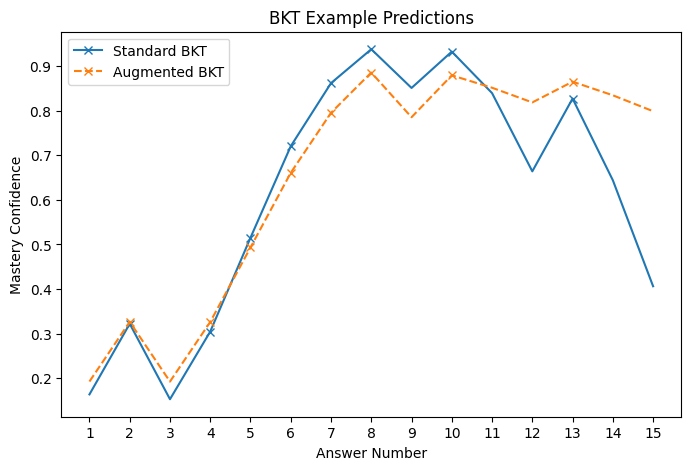

In [23]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
plt.figure(figsize=(8,5))

#answervals = [0,1,0,1,1,1,1,1,0,1,0,0,1,0,0,1]

mark_correct = [1,3,4,5,6,7,9,12]#,15]
mark_incorrect = [0,2,8,10,11,13,14]

plt.plot(x, pyBKT_preds2, label = 'Standard BKT', marker = 'x', markevery = mark_correct)
plt.plot(x, fast_preds, '--', label = 'Augmented BKT', marker = 'x', markevery = mark_correct)
#plt.plot(x, slow_preds, '--', label = 'Modified-Slow', marker = 'x', markevery = mark_correct)
#plt.plot(x, very_slow, '--', label = 'Modified-Very Slow', marker = 'x', markevery = mark_correct)

plt.xticks(x)
plt.xlabel("Answer Number")
plt.ylabel("Mastery Confidence")
plt.legend()
plt.title('BKT Example Predictions')

plt.savefig("Marked_renamed.png")
files.download("Marked_renamed.png")

plt.show()

In [ ]:
preds.sort_values(['UserId', 'SubjectId', 'DateAnswered'], ascending=[True, True, True], inplace = True)
preds.reset_index(drop = True, inplace = True)
preds

,QuestionId,UserId,AnswerId,IsCorrect,Name,SubjectId,Gender,PremiumPupil,max_CCR_for_subject,3 CCR,5 CCR,10 CCR,DateAnswered,TimeToAnswer
0,52,3,686571,1,"Factors, Multiples and Primes",37,1,0.0,3,1,0,0,2019-12-02 14:49:00,1.0
1,376,3,318132,1,"Factors, Multiples and Primes",37,1,0.0,3,1,0,0,2019-12-02 14:49:00,0.0
2,367,3,923962,1,"Factors, Multiples and Primes",37,1,0.0,3,1,0,0,2019-12-02 14:49:00,0.0
3,27,3,684889,1,Fractions,39,1,0.0,1,0,0,0,2019-12-02 14:47:00,0.0
4,383,3,790918,1,"Indices, Powers and Roots",40,1,0.0,1,0,0,0,2019-12-02 14:45:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139528,741,6140,941458,1,Transformations,278,2,0.0,3,1,0,0,2020-04-03 06:31:00,1.0
139529,271,6140,342151,0,Transformations,278,2,0.0,3,1,0,0,2020-04-03 06:31:00,0.0
139530,247,6140,865533,1,Transformations,278,2,0.0,3,1,0,0,2020-04-03 06:32:00,1.0
139531,411,6140,1199486,1,Transformations,278,2,0.0,3,1,0,0,2020-04-03 06:33:00,1.0


In [ ]:
predictions = []
subset = preds[0:]
length = len(subset)
index = 0
start = 0

while (index <= length):
  userId = subset.iloc[index]["UserId"]
  subjectId = subset.iloc[index]["SubjectId"]
  subjectName = subset.iloc[index]["Name"]

  #prior = priors_dict[subjectName]
  #learns = learns_dict[subjectName]
  #guesses = guesses_dict[subjectName]
  #slips = slips_dict[subjectName]

  while((subset.iloc[index]["UserId"] == userId) and (subset.iloc[index]["SubjectId"] == subjectId)):
    answers = subset["IsCorrect"][start:(index + 1)].values
    times = subset["TimeToAnswer"][start:(index + 1)].values

    prediction = predict(answers, times)#, prior, learns, guesses, slips)
    predictions.append(prediction)

    index += 1
  print(str(index) + " / " + str(length))

  start = index

Streaming output truncated to the last 5000 lines.
33371 / 139533
33375 / 139533
33415 / 139533
33420 / 139533
33487 / 139533
33489 / 139533
33518 / 139533
33525 / 139533
33532 / 139533
33596 / 139533
33600 / 139533
33603 / 139533
33615 / 139533
33622 / 139533
33703 / 139533
33704 / 139533
33717 / 139533
33829 / 139533
33837 / 139533
33845 / 139533
33857 / 139533
33901 / 139533
33989 / 139533
33997 / 139533
34031 / 139533
34048 / 139533
34069 / 139533
34085 / 139533
34086 / 139533
34181 / 139533
34189 / 139533
34196 / 139533
34218 / 139533
34236 / 139533
34288 / 139533
34293 / 139533
34326 / 139533
34382 / 139533
34383 / 139533
34392 / 139533
34503 / 139533
34507 / 139533
34511 / 139533
34512 / 139533
34550 / 139533
34632 / 139533
34636 / 139533
34652 / 139533
34660 / 139533
34680 / 139533
34696 / 139533
34791 / 139533
34797 / 139533
34804 / 139533
34826 / 139533
34843 / 139533
34855 / 139533
34859 / 139533
34903 / 139533
34904 / 139533
34909 / 139533
35020 / 139533
35024 / 139533
3503

IndexError: ignored

In [ ]:
print(len(predictions))
print(len(preds))

139533
139533


In [ ]:
subset["Prediction"] = predictions
newPreds = subset

<ipython-input-228-3bad0288fde8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Prediction"] = predictions


In [ ]:
newPreds

,QuestionId,UserId,AnswerId,IsCorrect,Name,SubjectId,Gender,PremiumPupil,max_CCR_for_subject,3 CCR,5 CCR,10 CCR,DateAnswered,TimeToAnswer,Prediction
0,52,3,686571,1,"Factors, Multiples and Primes",37,1,0.0,3,1,0,0,2019-12-02 14:49:00,1.0,0.493828
1,376,3,318132,1,"Factors, Multiples and Primes",37,1,0.0,3,1,0,0,2019-12-02 14:49:00,0.0,0.582410
2,367,3,923962,1,"Factors, Multiples and Primes",37,1,0.0,3,1,0,0,2019-12-02 14:49:00,0.0,0.665501
3,27,3,684889,1,Fractions,39,1,0.0,1,0,0,0,2019-12-02 14:47:00,0.0,0.411181
4,383,3,790918,1,"Indices, Powers and Roots",40,1,0.0,1,0,0,0,2019-12-02 14:45:00,0.0,0.411181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139528,741,6140,941458,1,Transformations,278,2,0.0,3,1,0,0,2020-04-03 06:31:00,1.0,0.161307
139529,271,6140,342151,0,Transformations,278,2,0.0,3,1,0,0,2020-04-03 06:31:00,0.0,0.138582
139530,247,6140,865533,1,Transformations,278,2,0.0,3,1,0,0,2020-04-03 06:32:00,1.0,0.248250
139531,411,6140,1199486,1,Transformations,278,2,0.0,3,1,0,0,2020-04-03 06:33:00,1.0,0.400277


In [ ]:
premiumMean = newPreds.groupby("PremiumPupil").mean()
predsNonPremium = newPreds.groupby("PremiumPupil").mean().iloc[0]
predsPremium = newPreds.groupby("PremiumPupil").mean().iloc[1]
premium = newPreds[newPreds["PremiumPupil"] == 1]
nonPremium = newPreds[newPreds["PremiumPupil"] == 0]

In [ ]:
userSubject = newPreds.groupby(["UserId", "SubjectId"]).tail(1)

In [ ]:
error3 = []
error5 = []
error10 = []

for i in range(len(userSubject)):
  temp = userSubject.iloc[i]
  error3.append(np.square(temp["Prediction"] - temp["3 CCR"]))
  error5.append(np.square(temp["Prediction"] - temp["5 CCR"]))
  error10.append(np.square(temp["Prediction"] - temp["10 CCR"]))

In [ ]:
userSubject["SE3"] = error3
userSubject["SE5"] = error5
userSubject["SE10"] = error10

<ipython-input-233-4c5765093650>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userSubject["SE3"] = error3
<ipython-input-233-4c5765093650>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userSubject["SE5"] = error5
<ipython-input-233-4c5765093650>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [ ]:
userSubjectGroup = userSubject.groupby("PremiumPupil").mean()

In [ ]:
m3 = (userSubject[userSubject["3 CCR"] == 1]).groupby("PremiumPupil").mean()
m5 = (userSubject[userSubject["5 CCR"] == 1]).groupby("PremiumPupil").mean()
m10 = (userSubject[userSubject["10 CCR"] == 1]).groupby("PremiumPupil").mean()

nm3 = (userSubject[userSubject["3 CCR"] == 0]).groupby("PremiumPupil").mean()
nm5 = (userSubject[userSubject["5 CCR"] == 0]).groupby("PremiumPupil").mean()
nm10 = (userSubject[userSubject["10 CCR"] == 0]).groupby("PremiumPupil").mean()

ma3 = userSubject[userSubject["3 CCR"] == 1].mean()
ma5 = userSubject[userSubject["5 CCR"] == 1].mean()
ma10 = userSubject[userSubject["10 CCR"] == 1].mean()

<ipython-input-235-5f38bb6e24d2>:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ma3 = userSubject[userSubject["3 CCR"] == 1].mean()
<ipython-input-235-5f38bb6e24d2>:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ma3 = userSubject[userSubject["3 CCR"] == 1].mean()
<ipython-input-235-5f38bb6e24d2>:10: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ma5 = userSubject[userSubject["5 CCR"] == 1].mean()
<ipython-input-235-5f38bb6e24d2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before

In [ ]:
print(ma3["Prediction"])
print(ma5["Prediction"])
print(ma10["Prediction"])

0.6520242598554109
0.8133283181490082
0.9528851685973538


In [ ]:
print(m3.iloc[0]["Prediction"])
print(m3.iloc[1]["Prediction"])

0.6754764057723642
0.5729224412400354


In [ ]:
print(m5.iloc[0]["Prediction"])
print(m5.iloc[1]["Prediction"])

0.8231342745740797
0.7746047963479601


In [ ]:
print(m10.iloc[0]["Prediction"])
print(m10.iloc[1]["Prediction"])

0.9632586855739848
0.9110767516915378


In [ ]:
print("How much the model over-predicts based on the choice of NCCR value")
for i in range(2):
  temp = userSubjectGroup.iloc[i]
  premium = i
  predict = temp["Prediction"]
  three = temp["SE3"]
  five = temp["SE5"]
  ten = temp["SE10"]
  print("Premium Pupil: " + str(premium) + "   3 CCR dif: " + str(three)+ "   5 CCR dif: " + str(five) + "   10 CCR dif: " + str(ten))

print("\n")
print("Ratio of predictions for non premium and premium pupils who have mastered at different thresholds")
print("N = 3:  " + str(m3.iloc[0]["Prediction"] / m3.iloc[1]["Prediction"]))
print("N = 5:  " + str(m5.iloc[0]["Prediction"] / m5.iloc[1]["Prediction"]))
print("N = 10: " + str(m10.iloc[0]["Prediction"] / m10.iloc[1]["Prediction"]))

print("\n")
print("Scaling vales used")
print("Mul1 = " + str(mul1))
print("Mul2 = " + str(mul2))
print("Mul3 = " + str(mul3))
print("Mul4 = " + str(mul4))

How much the model over-predicts based on the choice of NCCR value
Premium Pupil: 0   3 CCR dif: 0.16961263171162702   5 CCR dif: 0.15222714915228228   10 CCR dif: 0.25849106720727194
Premium Pupil: 1   3 CCR dif: 0.19304522971978774   5 CCR dif: 0.13235657902854395   10 CCR dif: 0.1957191297052411


Ratio of predictions for non premium and premium pupils who have mastered at different thresholds
N = 3:  1.179001479345722
N = 5:  1.0626506296564677
N = 10: 1.057275014191246


Scaling vales used
Mul1 = 2.5
Mul2 = 1.5
Mul3 = 0.5
Mul4 = 0.5


In [ ]:
print(userSubject["SE3"].mean())
print(userSubject["SE5"].mean())
print(userSubject["SE10"].mean())

0.17572374882101424
0.14704499303736213
0.24212042571355238
